# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


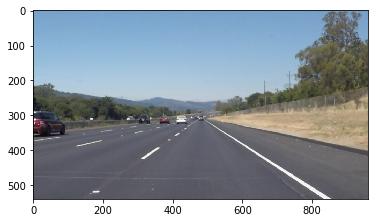

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math


def grayscale(img):
    """Applies the Grayscale transform
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.   
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[0, 0, 255], thickness=2):
    """  
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    """
    
    #linear Regression
    num_points_lh = 0.0
    num_points_rh = 0.0

    sum_lh_xi_yi =0.0
    sum_lh_xi =0.0
    sum_lh_yi =0.0
    sum_lh_xisq = 0.0
    
    sum_rh_xi_yi =0.0
    sum_rh_xi =0.0
    sum_rh_yi =0.0
    sum_rh_xisq = 0.0

    # region of interest
    imshape = img.shape
    y0_lh = imshape[0]
    y3_lh = int(imshape[0]/1.6)
    edge_lh_min = int(0.1*imshape[1])
    edge_lh = int(0.25*imshape[1])
    
    y0_rh = imshape[0]
    y3_rh = int(imshape[0]/1.6)
    edge_rh = int(0.95*imshape[1])
    edge_rh_min =  int(0.84*imshape[1])

# defining global values
    global b_mean_lh_old
    global a_mean_lh_old
    global b_mean_rh_old
    global a_mean_rh_old
    
# defining damping value
    damp = 0.15
#    damp = 0.15
    
#Separate lines neg/pos slope 
    for line in lines:
        for x1,y1,x2,y2 in line:
# Calculate of each point-pair slope, intersection and x0 at y0
            slope_calc = ((y2-y1)/(x2-x1))
            a_calc = y1 - slope_calc*x1
            x0_prog = (y0_lh-a_calc)/slope_calc

# Filter out lines only with unreasonable slope
            if slope_calc < -0.55 and slope_calc > -0.85 :
# Filter out parallel shifted lines:
                if x0_prog > edge_lh_min and x0_prog < edge_lh:
# Calculate terms for linear regression
                    num_points_lh +=2.0
                    sum_lh_xi_yi +=(x1*y1)
                    sum_lh_xi_yi +=(x2*y2)
                    sum_lh_xi +=(x1+x2)
                    sum_lh_xisq +=(x1*x1)
                    sum_lh_xisq +=(x2*x2)
                    sum_lh_yi += (y1+y2)
# Filter out lines only with unreasonable slope
            elif slope_calc > 0.49 and slope_calc < 0.7:
# Filter out parallel shifted lines:
                if x0_prog < edge_rh and x0_prog > edge_rh_min:
# Calculate terms for linear regression
                    num_points_rh +=2.0
                    sum_rh_xi_yi +=(x1*y1)
                    sum_rh_xi_yi +=(x2*y2)
                    sum_rh_xi += (x1+x2)
                    sum_rh_xisq +=(x1*x1)
                    sum_rh_xisq +=(x2*x2)
                    sum_rh_yi += (y1+y2)
                

# Calculate the mean slope and the intercept point of all lines on left side linear regression
# Are points on this side?       
    if num_points_lh > 0:
        b_mean_lh = (sum_lh_xi_yi-(1/num_points_lh)*sum_lh_xi*sum_lh_yi)/\
                    (sum_lh_xisq-(1/num_points_lh)*sum_lh_xi*sum_lh_xi)
        a_mean_lh = (1/num_points_lh)* sum_lh_yi -  b_mean_lh *(1/num_points_lh)* sum_lh_xi
# Start loop
        if b_mean_lh_old == 0.0:
            b_mean_lh_old = b_mean_lh
            a_mean_lh_old = a_mean_lh           
# Following loops
        else:
# Calculate new sloope and intersection point with damping and considering old values
            b_mean_lh = b_mean_lh_old + (damp)*(b_mean_lh-b_mean_lh_old)
            a_mean_lh = a_mean_lh_old + (damp)*(a_mean_lh-a_mean_lh_old)
            b_mean_lh_old = b_mean_lh
            a_mean_lh_old = a_mean_lh
# Calculate the intersection point at give y point in the range of interest
        x0_lh = int((y0_lh-a_mean_lh)/b_mean_lh)
        x3_lh = int((y3_lh-a_mean_lh)/b_mean_lh)
# Show lines in image with different colours left/right
        cv2.line(img, (x0_lh,y0_lh ), (x3_lh,y3_lh ), color=[2, 174, 0], thickness=5)
# No clear picture visible, but the step before => keep b_mean and a_mean constant    
    else:
        if b_mean_lh_old != 0:
            b_mean_lh = b_mean_lh_old
            a_mean_lh = a_mean_lh_old
# Calculate the intersection point at give y point in the range of interest
            x0_lh = int((y0_lh-a_mean_lh)/b_mean_lh)
            x3_lh = int((y3_lh-a_mean_lh)/b_mean_lh)
# Show lines in image with different colours left/right
            cv2.line(img, (x0_lh,y0_lh ), (x3_lh,y3_lh ), color=[2, 174, 0], thickness=5)
        
        
# Calculate the mean slope and the intercept point of all lines on right side linear regression
# Are points on this side?    
    if num_points_rh > 0:
        b_mean_rh = (sum_rh_xi_yi-(1/num_points_rh)*sum_rh_xi*sum_rh_yi)/\
                    (sum_rh_xisq-(1/num_points_rh)*sum_rh_xi*sum_rh_xi)
        a_mean_rh = (1/num_points_rh)* sum_rh_yi -  b_mean_rh *(1/num_points_rh)* sum_rh_xi
# Start loop
        if b_mean_rh_old == 0.0:
            b_mean_rh_old = b_mean_rh
            a_mean_rh_old = a_mean_rh           
# Following loops
        else:
# Calculate new sloope and intersection point with damping and considering old values
            b_mean_rh = b_mean_rh_old + (damp)*(b_mean_rh-b_mean_rh_old)
            a_mean_rh = a_mean_rh_old + (damp)*(a_mean_rh-a_mean_rh_old)
            b_mean_rh_old = b_mean_rh
            a_mean_rh_old = a_mean_rh
# Calculate the intersection point at give y point in the range of interest
        x0_rh = int((y0_rh-a_mean_rh)/b_mean_rh)
        x3_rh = int((y3_rh-a_mean_rh)/b_mean_rh)
# Show lines in image with different colours left/right
        cv2.line(img, (x0_rh,y0_rh ), (x3_rh,y3_rh ), color=[174, 2, 0], thickness=5)
# No clear picture visible, but the step before => keep b_mean and a_mean constant
    else:
        if b_mean_rh_old != 0: 
            b_mean_rh = b_mean_rh_old
            a_mean_rh = a_mean_rh_old
# Calculate the intersection point at give y point in the range of interest
            x0_rh = int((y0_rh-a_mean_rh)/b_mean_rh)
            x3_rh = int((y3_rh-a_mean_rh)/b_mean_rh)
# Show lines in image with different colours left/right
            cv2.line(img, (x0_rh,y0_rh ), (x3_rh,y3_rh ), color=[174, 2, 0], thickness=5)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.   
    Returns an image with hough lines drawn.
    """

    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

# only, if there is a yellow or white line
    if lines is not None:
        draw_lines(line_img, lines)

    return line_img


def weighted_img(img, initial_img, α=1., β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.    
    `initial_img` should be the image before any processing.    
    The result image is computed as follows:   
    initial_img * α + img * β + λ
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

### 1. CONVERT TO GREYSCALE

In [5]:
def cvt_graysc(image):
    return cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

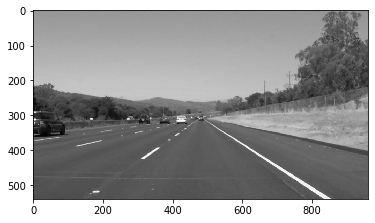

In [6]:
gray = cvt_graysc(image)
plt.imshow(gray,cmap='gray')

### 2. GAUSSIAN NOISE KERNAL

In [7]:
def gauss_blur(image):
    kernal_size = 7
    return cv2.GaussianBlur(image,(kernal_size,kernal_size),0)

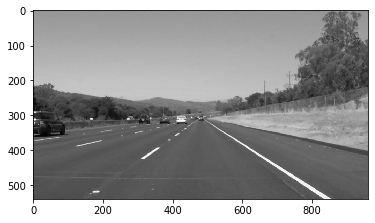

In [8]:
gaussian_blur = gauss_blur(gray)
plt.imshow(gray,cmap='gray')

### 3. CANNY EDGE DETECTION 

In [9]:
def canny_edge_det(image):
    low_thres = 50
    high_thres = 160
    return cv2.Canny(image,low_thres,high_thres)


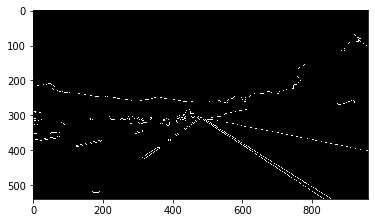

In [10]:
edges = canny_edge_det(gaussian_blur) 
plt.imshow(edges,cmap='gray')

### 4. MASKING THE REGION

In [11]:
def reg_mask(image):
    # Next we'll create a masked edges image using cv2.fillPoly()
    image_height = image.shape[0]
    image_width = image.shape[1]
    mask = np.zeros_like(image)   
    ignore_mask_color = 255
    imshape = image.shape
    if len(imshape) > 2:
        chann_ct = imshape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255) * chann_ct
    else:
        ignore_mask_color = 255
    vertices = np.array([[(0.1*imshape[1],imshape[0]),(0.48*imshape[1], imshape[0]/1.7),(0.52*imshape[1], imshape[0]/1.7), (0.95*imshape[1],imshape[0])]], dtype=np.int32)
    #vertices = np.array([[(0,shape_im[0]),(490, 320), (500, 320), (shape_im[1],shape_im[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    return cv2.bitwise_and(image, mask)

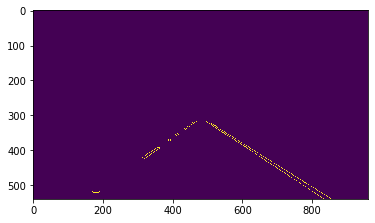

In [12]:
masked_edges = reg_mask(edges)
plt.imshow(masked_edges)

### 5. HOUGH TRANSFORM 

In [13]:
def hough_trans(image):    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/150 # angular resolution in radians of the Hough grid
    threshold = 8     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 12 #minimum number of pixels making up a line
    max_line_gap = 10    # maximum gap in pixels between connectable line segments
    
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    return cv2.HoughLinesP(image, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

lines = hough_trans(masked_edges)

In [36]:
def lane_display(lines,image):
    lane_im = np.copy(image)*0 #creating a blank to draw lines on
    lane_cr = (0,0,255)
    lane_th = 10
    
    left_slopes = []
    left_intercepts = []
    
    right_slopes = []
    right_intercepts = []
    
    y_max = image.shape[0]
    y_min = lane_im.shape[0]
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            m, b = np.polyfit((x1, x2), (y1, y2), 1)
            y_min = min(y_min, y1, y2)
            if(m > 0):
                left_slopes.append(m)
                left_intercepts.append(b)
            if(m < 0):
                right_slopes.append(m)
                right_intercepts.append(b)
    
    if len(left_slopes) > 0: 
        # Draw the left lane
        left_slope = np.median(left_slopes)
        left_intercept = np.median(left_intercepts)
        left_x_min = int((y_min-left_intercept)/left_slope)
        left_x_max = int((y_max-left_intercept)/left_slope)
        cv2.line(lane_im, (left_x_min, y_min), (left_x_max, y_max), lane_cr, lane_th)
    if len(right_slopes) > 0:
        # Draw the right lane
        right_slope = np.median(right_slopes)
        right_intercept = np.median(right_intercepts)
        right_x_min = int((y_min-right_intercept)/right_slope)
        right_x_max = int((y_max-right_intercept)/right_slope)
        cv2.line(lane_im, (right_x_min, y_min), (right_x_max, y_max), lane_cr, lane_th)
    
    return cv2.addWeighted(image, 0.8, lane_im, 1, 0) 
    


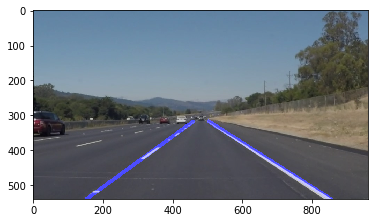

In [37]:
lanes = lane_display(lines, image)
plt.imshow(lanes)

### LANE IDENTIFICATION FUNCTION

In [16]:
def lane_iden_final(image):
    gray = cvt_graysc(image)
    filtered = gauss_blur(gray)
    edges = canny_edge_det(filtered)
    masked = reg_mask(edges)
    lines = hough_trans(masked)
    
    return lane_display(lines, image)

### IMAGE TEST

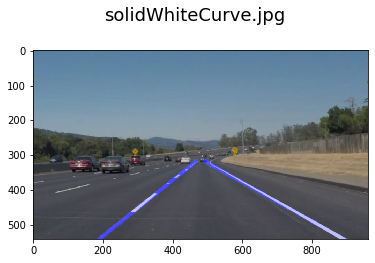

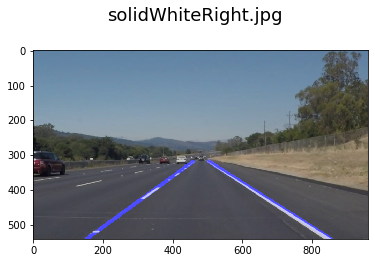

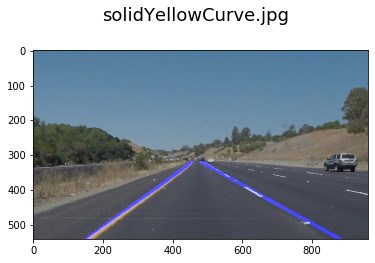

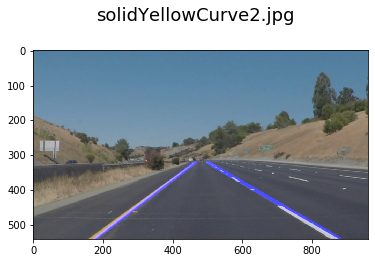

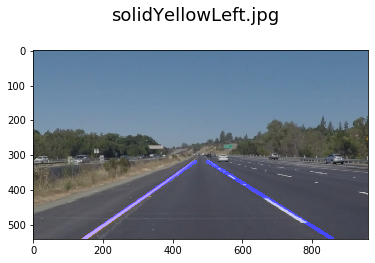

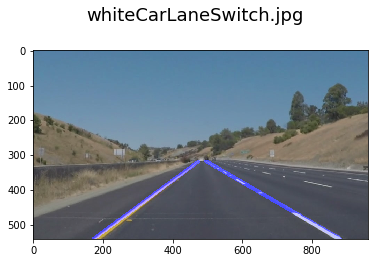

In [17]:
test_images = os.listdir("test_images/")

if not os.path.isdir("results"):
    os.mkdir("results")

for i in range(0, len(test_images)):
    # Read image
    img = mpimg.imread(os.path.join("test_images", test_images[i]))
    # Run the pipeline
    img_out = lane_iden_final(img)
    # Save output
    mpimg.imsave(os.path.join("results", test_images[i]), img_out)
    # Show output
    plt.figure()
    plt.suptitle(test_images[i], fontsize=18)
    plt.imshow(img_out)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
#lane_iden_final function used

Let's try the one with the solid white lane on the right first ...

In [20]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(lane_iden_final) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 5.79 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [22]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(lane_iden_final)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 19.6 s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [33]:
challenge_output = 'test_videos_output/extra.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(lane_iden_final)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Moviepy - Building video test_videos_output/extra.mp4.


t:  20%|██        | 51/251 [04:19<00:08, 22.69it/s, now=None]
                                                             


Moviepy - Writing video test_videos_output/extra.mp4



t:  20%|██        | 51/251 [03:33<00:08, 22.54it/s, now=None]

t:   0%|          | 0/251 [00:00<?, ?it/s, now=None]

t:   2%|▏         | 4/251 [00:00<00:07, 32.88it/s, now=None]

t:   3%|▎         | 8/251 [00:00<00:07, 33.70it/s, now=None]

t:   5%|▍         | 12/251 [00:00<00:07, 33.20it/s, now=None]

t:   6%|▌         | 15/251 [00:00<00:07, 31.89it/s, now=None]

t:   8%|▊         | 19/251 [00:00<00:07, 32.41it/s, now=None]

t:   9%|▉         | 22/251 [00:00<00:07, 31.38it/s, now=None]

t:  10%|█         | 26/251 [00:00<00:07, 31.51it/s, now=None]

t:  12%|█▏        | 30/251 [00:00<00:06, 31.83it/s, now=None]

t:  14%|█▎        | 34/251 [00:01<00:06, 32.53it/s, now=None]

t:  15%|█▌        | 38/251 [00:01<00:06, 32.16it/s, now=None]

t:  17%|█▋        | 42/251 [00:01<00:06, 32.53it/s, now=None]

t:  18%|█▊        | 46/251 [00:01<00:06, 32.31it/s, now=None]

t:  20%|█▉        | 50/251 [00:01<00:06, 29.01it/s, now=None]

OverflowError: Python int too large to convert to C long



t:  20%|██        | 51/251 [00:20<00:06, 29.01it/s, now=None]

In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))